In [1]:
# Google Colabでkaggle.jsonをアップロード
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kojikojipro","key":"04c6e3329de941099c00e7a9a89a384a"}'}

In [0]:
# Google Colabでkaggle.jsonをフォルダ移動
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# kaggle.jsonの権限変更
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Google Colabでデータセットをダウンロード
!pip install kaggle
!kaggle competitions download -c digit-recognizer

 82% 5.00M/6.09M [00:00<00:00, 31.3MB/s]
100% 6.09M/6.09M [00:00<00:00, 29.8MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 74.0MB/s]
 55% 5.00M/9.16M [00:00<00:00, 31.0MB/s]
100% 9.16M/9.16M [00:00<00:00, 44.9MB/s]


In [4]:
# データセットを解凍
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import torch.utils.data as data

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
train = pd.read_csv('train.csv').astype(float)
test = pd.read_csv('test.csv').astype(float)

In [0]:
train_y = train.loc[:, 'label'].astype(int)
train_x = train.drop('label', axis=1)

In [0]:
train_x = train_x / 255.0
test = test / 255.0

train_len = len(np.array(train_x))
train_x = torch.FloatTensor(np.array(train_x)).view(train_len, 1, 28, 28).to(device)
train_y = torch.LongTensor(np.array(train_y)).to(device)

test_len = len(np.array(test))
test = torch.FloatTensor(np.array(test)).view(test_len, 1, 28, 28).to(device)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.linear1 = nn.Linear(256 * 3 * 3, 120)
        self.linear2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = f.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [0]:
EPOCH_NUM = 50
BATCH_SIZE = 1024

train = data.TensorDataset(train_x, train_y)
train_loader = data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [8]:
loss_log = []
for epoch in range(1, EPOCH_NUM + 1):
    total_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()

        output = net(x)
        loss = criterion(output, y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    ave_loss = total_loss / BATCH_SIZE
    loss_log.append(ave_loss)

    print('Epoch: %d | Average Loss: %d' % (epoch, ave_loss))

Epoch: 1 | Average Loss: 0
Epoch: 2 | Average Loss: 0
Epoch: 3 | Average Loss: 0
Epoch: 4 | Average Loss: 0
Epoch: 5 | Average Loss: 0
Epoch: 6 | Average Loss: 0
Epoch: 7 | Average Loss: 0
Epoch: 8 | Average Loss: 0
Epoch: 9 | Average Loss: 0
Epoch: 10 | Average Loss: 0
Epoch: 11 | Average Loss: 0
Epoch: 12 | Average Loss: 0
Epoch: 13 | Average Loss: 0
Epoch: 14 | Average Loss: 0
Epoch: 15 | Average Loss: 0
Epoch: 16 | Average Loss: 0
Epoch: 17 | Average Loss: 0
Epoch: 18 | Average Loss: 0
Epoch: 19 | Average Loss: 0
Epoch: 20 | Average Loss: 0
Epoch: 21 | Average Loss: 0
Epoch: 22 | Average Loss: 0
Epoch: 23 | Average Loss: 0
Epoch: 24 | Average Loss: 0
Epoch: 25 | Average Loss: 0
Epoch: 26 | Average Loss: 0
Epoch: 27 | Average Loss: 0
Epoch: 28 | Average Loss: 0
Epoch: 29 | Average Loss: 0
Epoch: 30 | Average Loss: 0
Epoch: 31 | Average Loss: 0
Epoch: 32 | Average Loss: 0
Epoch: 33 | Average Loss: 0
Epoch: 34 | Average Loss: 0
Epoch: 35 | Average Loss: 0
Epoch: 36 | Average Loss: 0
E

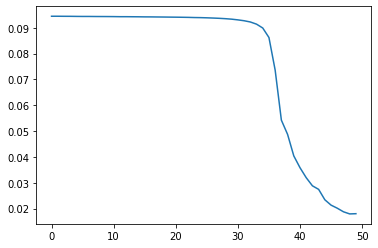

In [9]:
plt.plot([i for i in range(EPOCH_NUM)], loss_log)

In [17]:
net.eval()

# GPUメモリがオーバーフローするのでテストデータをスライスする
test_slice = []
for i in range(0, len(test.to('cpu').numpy()), 1000):
    test_slice.append(test[i: i + 1000])

outputs = []
for test_item in test_slice:
    outputs.append(torch.max(net(test_item.to(device)), 1)[1])
result = torch.cat(outputs, dim=0).to('cpu')
result

tensor([3, 0, 9,  ..., 3, 9, 3])

In [0]:
submission = pd.DataFrame()
submission['ImageId'] = [i for i in range(1, len(result.numpy()) + 1)]
submission['Label'] = result.numpy()
submission.to_csv('digit-recognizer-submission.csv', index=False)

0.75642